<a href="https://colab.research.google.com/github/itaewonflow/lecture-DeepLearning/blob/main/Training%20Techniques%20Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning**
## **Train Techniques Practice**

---
**Intro:** Deep Learning 모델의 정확도를 높이기 위한 많은 기술적 배경이 있습니다. Learning Rate, Optimizer, Data Augumentation, Dropout와 같이 많이 사용하는 기술적 사항들이 있는데요. 각 요소들이 모델에 어떤 영향을 미치는지 프로그램을 통해 알아보도록 하겠습니다.

다양한 학습을 많이 돌려보기 위해 CIFAR10보다는 쉽고 MNIST보다는 어려운 **Fashion MNIST** 데이터를 사용하겠습니다.

#**Data Introduce : Fashion MNIST**
Fashion MNIST는 MNIST와 같은 포멧이지만 데이터 이미지와 클래스가 의류인 데이터셋입니다. 전체 데이터셋은 28x28크기의 흑백 이미지 60000장으로 50000장의 Train dataset과, 10000장의 Test dataset으로 이루어져 있습니다. 또한 10개의 클래스를 가지고 있는점은 MNIST와 같습니다.


---


10개의 레이블은 다음과 같습니다.
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot


Github MNIST Fashion
: https://github.com/zalandoresearch/fashion-mnist

#**Programming Part for Fashion MNIST**

In [2]:
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np

import matplotlib.pyplot as plt

##**Coding Explanation**

###**Data Set Loding**
- **line 01] datasets.FashionMNIST** : torchvision에서 제공하는 dataset에 Fashion MNIST를 제공하고 있어 데이타 로딩이 손쉽게 가능합니다.
- **line 03] fmnist[i][0]** : 0번이 이미지, 1번은 레이블로 이미지만 로딩합니다.
- **line 04] make_grid** : 텐서 형태의 이미지를 그리드 형태로 변환합니다.

100%|██████████| 26421880/26421880 [00:14<00:00, 1781901.95it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 117160.77it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 479636.20it/s] 


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16419982.50it/s]


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



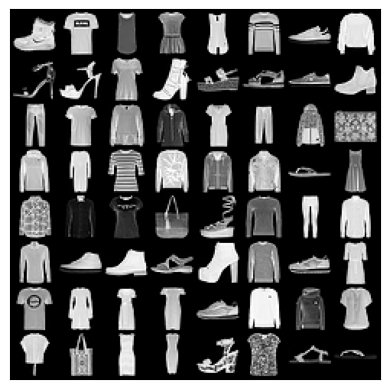

In [3]:
fmnist = datasets.FashionMNIST(root='fmnist', train=True, download=True, transform=transforms.ToTensor())

samples = [fmnist[i][0] for i in range(8*8)]
imgs = utils.make_grid(samples)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(imgs)

##**Coding Explanation**

###**Model**
- 간단한 데이터셋인 만큼 간단한 모델로 실습을 진행해 봅니다. **<font color=red>3개의 Convolution Layer, 3개의 MaxPool, 1개의 FC Layer를 사용한 모델</font>**로 구현합니다.
- **line 05**] _make_layer(1, 8)** : 흑백이미지이기 때문에 1부터 시작한다.
- **line 08**] nn.Linear(32, num_classes) ** : 10개의 class이기 때문에 10개로 분류하고 출력하는 Layer를 만듭니다.
- **line 23**] F.adaptive_avg_pool2d(out, (1, 1))** : adaptive_avg_pool2d은 avg pooling을 수행하는데, 커널과 스트라이드를 지정하는 이전 방법에 비해, output size만 지정하면 자체적으로 커널사이즈와 스트라이드를 계산하여 셋팅하는 기능을 제공합니다.



In [4]:
class MyNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyNet, self).__init__()

        self.layer1 = self._make_layer(1, 8)
        self.layer2 = self._make_layer(8, 16)
        self.layer3 = self._make_layer(16, 32)
        self.linear = nn.Linear(32, num_classes)

    def _make_layer(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, (1, 1)) # 32x1x1
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [5]:
print(MyNet())

MyNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=32, out_features=10, bias=True)
)


## **Baseline 학습하기**

- 모든 실험에서 **가장 중요한 것은 Baseline 즉 기준점을 잡는 것입니다**. Baseline을 먼저 정한후에 다음에 진행하는 실험이 Baseline보다 얼마나 좋아졌는지를 비교해가면서 실험을 진행해야 현재 내가 얼마나 잘하고 있는지를 계속 비교하면서 실험해 나아갈 수 있습니다.

- 본 진행에서는 아래와 같이 Baseline을 정하겠습니다.

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 10 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | Adam |
| Learning Rate | 0.001 |

In [6]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

False cpu


In [7]:
seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

##**Coding Explanation**

### **Data Loader Part**

In [8]:
from torch.utils.data import random_split


def get_fmnist_dataloaders(batch_size, val=0.2, num_workers=0):
  # transform
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  # split                       v FashinMNIST 불러오기
  mnist_train_origin = datasets.FashionMNIST(root='fmnist', train=True, download=True, transform=transform)
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples

  # dataset
  mnist_train, mnist_val = random_split(mnist_train_origin, (train_samples, val_samples))
  mnist_test = datasets.FashionMNIST(root='fmnist', train=False, download=True, transform=transform)

  # dataloader
  train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = DataLoader(dataset=mnist_val, batch_size=batch_size, num_workers=num_workers)
  test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, num_workers=num_workers)

  return train_loader, val_loader, test_loader

##**Coding Explanation**

### **Loding Train Part**

In [9]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data, targets = data.to(device), targets.to(device)   # data device로 이동

    optimizer.zero_grad()       # gradient 초기화
    outputs = model(data)       # forward
    loss = criterion(outputs, targets)    # loss 계산
    loss.backward()             # gradient 계산
    optimizer.step()            # weight update

    running_loss += loss.item()

    # Accuracy 계산
    _, predicted = torch.max(outputs, 1)
    correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f"[{epoch}] train loss: {running_loss/len(dataloader):.4f} train acc: {correct}/{data_num} ({acc:.2f}%)")

  return running_loss/len(dataloader), acc

##**Coding Explanation**

### **Validation Part**

In [10]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data, targets = data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader), acc

##**Coding Explanation**

### **Loding Test Part**

In [11]:
def test(model, dataloader, device):
  # eval 모드
  model.eval()

  # 테스트 통계
  correct = 0

  with torch.no_grad():
    for data, targets in dataloader:
      data, targets = data.to(device), targets.to(device)

      outputs = model(data)    # forward

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

##**Coding Explanation**

### **Execution Training Data**

- 약 5분 실행

In [12]:
# Hyperparameters
# Training
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001

checkpoint = None

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

start_epoch = 0

# load
if checkpoint is not None:
  ckpt = torch.load(checkpoint)
  model.load_state_dict(ckpt["model"])
  optimizer.load_state_dict(ckpt["optimizer"])
  start_epoch = ckpt["epoch"] + 1
  print("Model Loaded:", checkpoint)
  print("Last Epoch:", start_epoch, f"loss: {ckpt['loss']:.4f}", )

# Start Training
train_losses = []
val_losses = []

for epoch in range(start_epoch, EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, tacc = validation(model, val_loader, criterion, epoch, device)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader, device)

[0] train loss: 0.9851 train acc: 34273/48000 (71.40%)
[0] valid loss: 0.6259 valid acc: 9376/12000 (78.13%)

[1] train loss: 0.5054 train acc: 39784/48000 (82.88%)
[1] valid loss: 0.4879 valid acc: 10024/12000 (83.53%)

[2] train loss: 0.4169 train acc: 41106/48000 (85.64%)
[2] valid loss: 0.4328 valid acc: 10240/12000 (85.33%)

[3] train loss: 0.3736 train acc: 41706/48000 (86.89%)
[3] valid loss: 0.3910 valid acc: 10348/12000 (86.23%)

[4] train loss: 0.3448 train acc: 42162/48000 (87.84%)
[4] valid loss: 0.3590 valid acc: 10506/12000 (87.55%)

[5] train loss: 0.3229 train acc: 42517/48000 (88.58%)
[5] valid loss: 0.3813 valid acc: 10383/12000 (86.53%)

[6] train loss: 0.3093 train acc: 42748/48000 (89.06%)
[6] valid loss: 0.3236 valid acc: 10681/12000 (89.01%)

[7] train loss: 0.2974 train acc: 42869/48000 (89.31%)
[7] valid loss: 0.3289 valid acc: 10601/12000 (88.34%)

[8] train loss: 0.2871 train acc: 43089/48000 (89.77%)
[8] valid loss: 0.3224 valid acc: 10669/12000 (88.91%)

[9

##**Into the Real Practice**

- <font color="red">Tensorboard는 23년까지 Dev를 지원한다는 것으로 공지되었습니다.</font> (https://tensorboard.dev/)
- **<u>새로운 내용으로 안내하겠습니다. SKIP부분은 넘어가세요.</u>**
- 지금까지는 하나의 모델에 하나의 실험만 진행했지만 좋은 모델은 한번의 학습으로 만들어지지 않습니다. 여러가지 파라미터를 변경하며 진행하는 실험에서 좋은 학습모델이 만들어지게 됩니다.
- 이런 경우 매번 실험에서 어떤 하이퍼파라미터를 사용했는지 로그는 어땠는지를 남기는 작업이 필요한데요. 이를 위해 <u>**실험관리**</u>라는 개념이 필요해졌습니다. 다양한 실험관리 툴들이 있지만 쉽고 많이 사용되는 **<u>Tensorboard를 이용해서 실험관리 및 로깅하는 방법</u>**을 알아보겠습니다.
- Tensorboard는 원래 Tensorflow에서 만들어진 실험관리 및 로깅 도구로 스칼라 값 뿐 아니라 이미지, 임베딩, 오디오등 다양한 값을 로깅할 수 있습니다. Pytorch에서도 직접 실험관리 및 로깅툴을 만드려는 시도가 있었지만 Tensorboard에 기록할수 있는 기능이 추가되면서 Tensorboard가 널리 사용되게 되었습니다.
- Tensorboard 를 사용하기 위해서 몇가지 코드를 수정하겠습니다.

##**(SKIP) Coding Explanation**

### (SKIP) **TensorBoard Adaption**

- **line 02**] SummaryWriter : TensorBoard를 적용하기 위한 Library
- **line 05**] LOGGING_ROOT : Log를 저장할 위치
- **line 27**] SummaryWriter : TensorBoard에 저장을 한다. add_scalars를 통해 각 내용을 저장한다.
- **line 36**] add_scalars : 중요한 내용으로 epoch을 지정한다. 각 epoch마다 결과를 저장하기 위함이다.
- **line 38**] flush : add_scalars가 되자마자 결과를 파일에 저장하기 위한 명령어



In [13]:
# # PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# from datetime import datetime

# LOGGING_ROOT = 'runs/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = 'Baseline_{}'.format(timestamp)

# # Hyperparameters
# EPOCH = 10
# BATCH_SIZE = 128
# NUM_WORKERS = 1
# LR = 0.001

# # Model
# model = MyNet()
# model = model.to(device)

# # MNIST dataloader
# train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# # Loss, Optimizer 정의
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LR)

# # Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# # Start Training
# for epoch in range(EPOCH):
#   tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
#   vloss, vacc = validation(model, val_loader, criterion, epoch, device)

#   # train_losses.append(tloss)
#   # val_losses.append(vloss)
#   writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
#   writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
#   writer.flush()

# test(model, test_loader, device)

### **(SKIP) TensorBoard Usage**


In [14]:
# !pip install tensorrt

In [15]:
# %load_ext tensorboard
# %tensorboard --load_fast=false --logdir runs/

## (SKIP) TroubleShotting : Tensorboard Run Error

- **<u>Port 6006 is in use by another program</u>**. Either identify and stop that program, or start the server with a different port. : 와 같이 포트를 이미 사용하고 있다는 메세지가 나온다면 아래와 같이 해당 포트를 사용하는 포트를 확인하고 해당 PID를 KILL한 후 다시 실행한다.

In [16]:
# !lsof -i:6006

In [17]:
# !kill PID "1898"

## **모델 성능 향상을  튜닝 포인트**
### **Learning Rate**

- **<u>Learning Rate</u>**는 가장 많이 튜닝하는 것중의 하나로 Optimizer에서 Back-Propagation으로 계산된 Gradient를 얼만큼의 보폭으로 이동시킬지를 의미합니다.
- Learning Rate를 조절해가면서 학습 결과를 비교해 보겠습니다.
- 1, 0.001, 0.000001 로 조정 진행

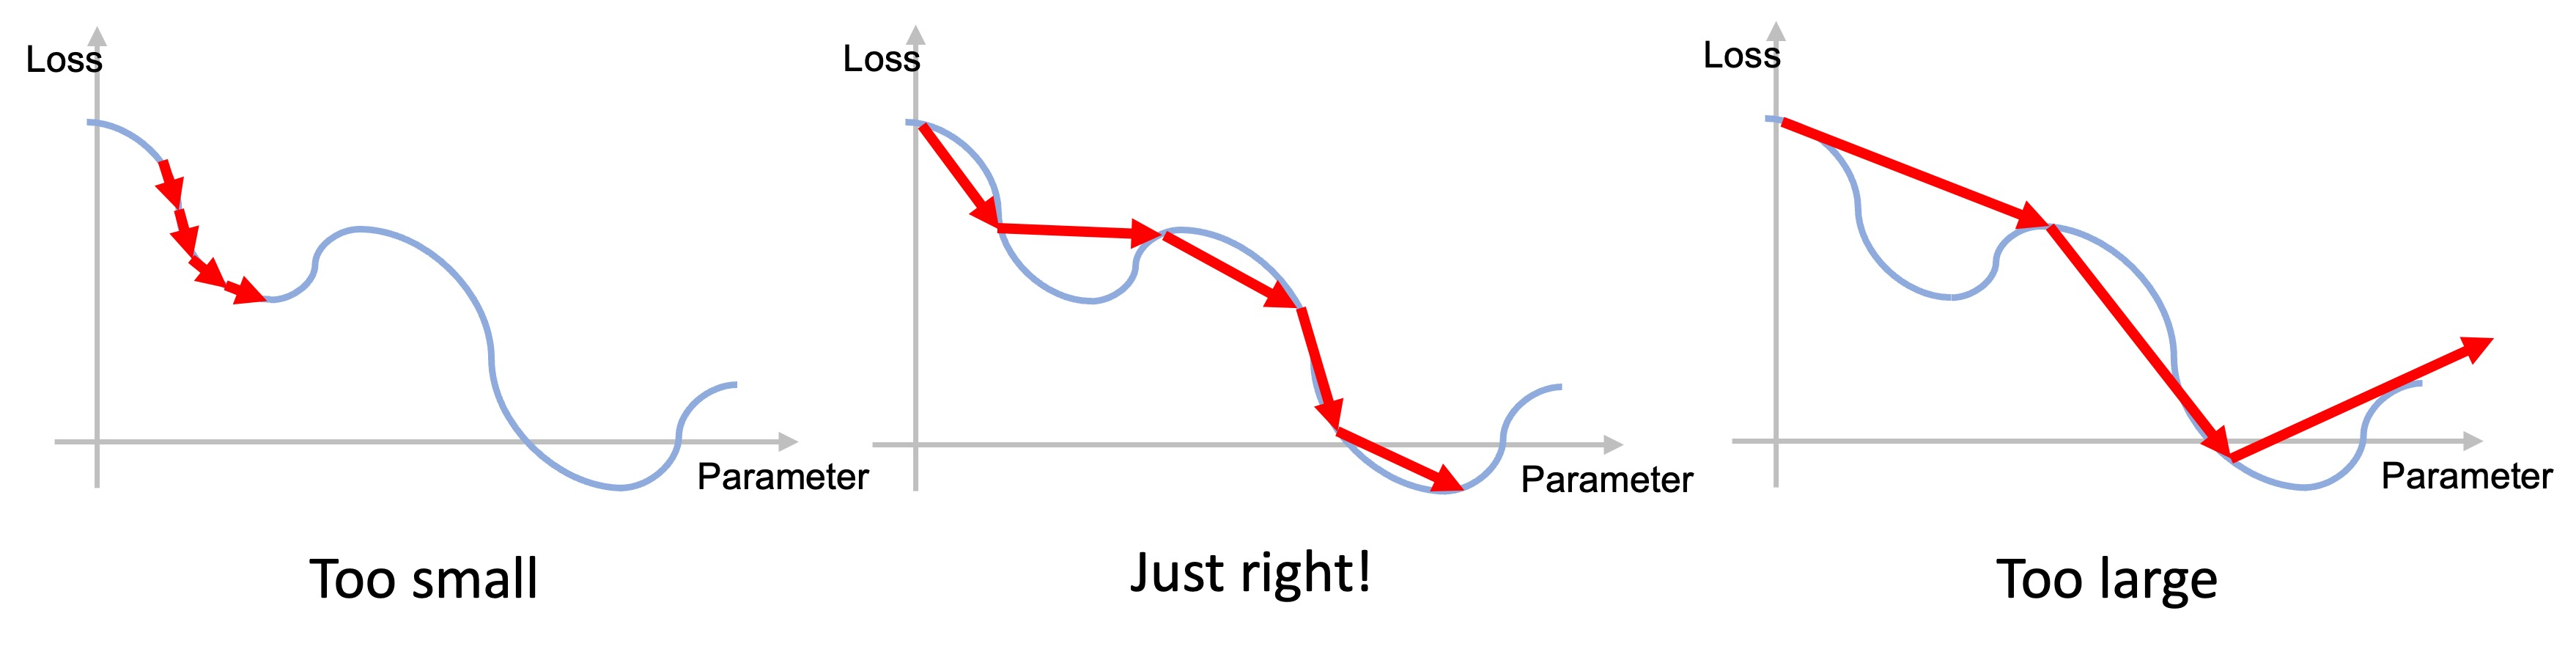

In [18]:
def exp_with_lr(lr):
  from datetime import datetime

  # LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/LR/'
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  EXP = f'LR_{lr}_{timestamp}'

  # Hyperparameters
  EPOCH = 10
  BATCH_SIZE = 128
  NUM_WORKERS = 1
  LR = lr

  # Model
  model = MyNet()
  model = model.to(device)

  # MNIST dataloader
  train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

  # Loss, Optimizer 정의
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=LR)

  # Logging
  # writer = SummaryWriter(LOGGING_ROOT + EXP)

  # Start Training
  for epoch in range(EPOCH):
    tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
    vloss, vacc = validation(model, val_loader, criterion, epoch, device)

    # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
    # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
    # writer.flush()

  test(model, test_loader, device)

In [19]:
exp_with_lr(1)

[0] train loss: 0.7097 train acc: 35204/48000 (73.34%)
[0] valid loss: 0.5319 valid acc: 9672/12000 (80.60%)

[1] train loss: 0.4271 train acc: 40408/48000 (84.18%)
[1] valid loss: 0.3785 valid acc: 10344/12000 (86.20%)

[2] train loss: 0.3762 train acc: 41369/48000 (86.19%)
[2] valid loss: 0.3709 valid acc: 10396/12000 (86.63%)

[3] train loss: 0.3445 train acc: 41867/48000 (87.22%)
[3] valid loss: 0.3280 valid acc: 10579/12000 (88.16%)

[4] train loss: 0.3307 train acc: 42127/48000 (87.76%)
[4] valid loss: 0.3196 valid acc: 10591/12000 (88.26%)

[5] train loss: 0.3121 train acc: 42474/48000 (88.49%)
[5] valid loss: 0.3158 valid acc: 10672/12000 (88.93%)

[6] train loss: 0.3010 train acc: 42716/48000 (88.99%)
[6] valid loss: 0.3394 valid acc: 10503/12000 (87.53%)

[7] train loss: 0.2908 train acc: 42876/48000 (89.32%)
[7] valid loss: 0.2967 valid acc: 10744/12000 (89.53%)

[8] train loss: 0.2799 train acc: 43079/48000 (89.75%)
[8] valid loss: 0.3186 valid acc: 10646/12000 (88.72%)

[9

In [20]:
exp_with_lr(1e-3) # 0.001

[0] train loss: 2.2630 train acc: 10506/48000 (21.89%)
[0] valid loss: 2.1443 valid acc: 4353/12000 (36.28%)

[1] train loss: 2.0551 train acc: 20646/48000 (43.01%)
[1] valid loss: 1.9714 valid acc: 5715/12000 (47.62%)

[2] train loss: 1.8941 train acc: 24964/48000 (52.01%)
[2] valid loss: 1.8180 valid acc: 6510/12000 (54.25%)

[3] train loss: 1.7472 train acc: 27111/48000 (56.48%)
[3] valid loss: 1.6745 valid acc: 7167/12000 (59.72%)

[4] train loss: 1.6152 train acc: 29153/48000 (60.74%)
[4] valid loss: 1.5532 valid acc: 7516/12000 (62.63%)

[5] train loss: 1.5020 train acc: 30519/48000 (63.58%)
[5] valid loss: 1.4474 valid acc: 7811/12000 (65.09%)

[6] train loss: 1.4071 train acc: 31697/48000 (66.04%)
[6] valid loss: 1.3615 valid acc: 8089/12000 (67.41%)

[7] train loss: 1.3268 train acc: 32504/48000 (67.72%)
[7] valid loss: 1.2855 valid acc: 8242/12000 (68.68%)

[8] train loss: 1.2572 train acc: 33197/48000 (69.16%)
[8] valid loss: 1.2195 valid acc: 8358/12000 (69.65%)

[9] train 

In [21]:
exp_with_lr(1e-6) # 0.000001

[0] train loss: 2.5600 train acc: 4744/48000 (9.88%)
[0] valid loss: 2.5511 valid acc: 1256/12000 (10.47%)

[1] train loss: 2.5585 train acc: 4744/48000 (9.88%)
[1] valid loss: 2.5497 valid acc: 1256/12000 (10.47%)

[2] train loss: 2.5572 train acc: 4744/48000 (9.88%)
[2] valid loss: 2.5469 valid acc: 1256/12000 (10.47%)

[3] train loss: 2.5555 train acc: 4744/48000 (9.88%)
[3] valid loss: 2.5420 valid acc: 1256/12000 (10.47%)

[4] train loss: 2.5541 train acc: 4744/48000 (9.88%)
[4] valid loss: 2.5483 valid acc: 1256/12000 (10.47%)

[5] train loss: 2.5525 train acc: 4744/48000 (9.88%)
[5] valid loss: 2.5450 valid acc: 1256/12000 (10.47%)

[6] train loss: 2.5510 train acc: 4744/48000 (9.88%)
[6] valid loss: 2.5380 valid acc: 1256/12000 (10.47%)

[7] train loss: 2.5496 train acc: 4744/48000 (9.88%)
[7] valid loss: 2.5388 valid acc: 1256/12000 (10.47%)

[8] train loss: 2.5479 train acc: 4744/48000 (9.88%)
[8] valid loss: 2.5336 valid acc: 1256/12000 (10.47%)

[9] train loss: 2.5467 train

In [22]:
# %load_ext tensorboard
# %tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/ch5/runs/LR'

## **모델 성능 향상을  튜닝 포인트**
### **Optimizer**

- **<u>Optimizer</u>**는 Back-Propagation으로 계산된 Gradient를 어떻게 가중치에 업데이트할지 결정하는 역할을하며 학습에 많은 영향을 끼칩니다.
- 딥러닝의 발전에 따라 어떻게하면 더 빨리 더 좋은 가중치를 학습하게 할지 지속적인 연구가 이루어졌고 그 결과로 다양한 Optimizer가 나왔습니다.
- Optimizer의 종류
  - [그림으로 확인하기](https://blog.kakaocdn.net/dn/cQGW6d/btrgg4UpreR/xZ7rEtNOOgv33kVoszf771/img.webp)
  - 많은 Optimizer가 있지만 그 중 **<font color=red>Adam</font>**이 가장 좋은 성능을 보이는 면이 있습니다.
  - GD: 모든 자료를 이용해서 기울기를 구해 방향을 찾는다
  - SGD: 모든 자료를 사용하면 계산시간이 너무 오래 걸리니, 몇 개씩만 보고 이동한다.
  - Momentum: (스탭방향 중심)스탭을 계산해서 움직인 후, 내려오던 방향으로 관성을 유지 하면서 이동한다.
  - Adagrad: (스탭사이즈 중심)안 가본 곳은 성큼성큼 빨리가서 훑어보고 많이 가본곳은 세밀하게 탐색
  - RMSProp: (스탭사이즈 중심)보폭 줄이면서 세밀하게 탐색하되, 이전 상황을 보아가면서 줄이자
  - **Adam**: (스탭방향+스탭사이즈)RMSProp+Momentum방향도 따지고 스탭사이즈도 조절하자
  

### SGD와 Momentum, Adam 비교

| Hyperprams Name | SGD Only | SGD+Momentum |Adam|
| --------------- | ----------------------------- |----------------------------- |----------------------------- |
| Model | MyNet |MyNet |MyNet |
| Epochs | 10 |10 |10 |
| BatchSize | 128 |128 |128 |
| Loss | Cross Entropy |Cross Entropy |Cross Entropy |
| Optimizer | ***SGD*** | ***SGD*** |***Adam***
| Learning Rate | 0.01 |0.01 |0.01 |
| Momentum | ***0.0*** |***0.09*** |***0.0*** |


##SGD Only

In [23]:
from datetime import datetime

# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Optim/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'SGD-Only_{timestamp}'

# Hyperparameters
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 1.6199 train acc: 26236/48000 (54.66%)
[0] valid loss: 1.2228 valid acc: 8355/12000 (69.62%)

[1] train loss: 1.0261 train acc: 34803/48000 (72.51%)
[1] valid loss: 0.8874 valid acc: 8917/12000 (74.31%)

[2] train loss: 0.8038 train acc: 35970/48000 (74.94%)
[2] valid loss: 0.7468 valid acc: 9085/12000 (75.71%)

[3] train loss: 0.6970 train acc: 36926/48000 (76.93%)
[3] valid loss: 0.6777 valid acc: 9254/12000 (77.12%)

[4] train loss: 0.6341 train acc: 37597/48000 (78.33%)
[4] valid loss: 0.6312 valid acc: 9360/12000 (78.00%)

[5] train loss: 0.5886 train acc: 38192/48000 (79.57%)
[5] valid loss: 0.5829 valid acc: 9541/12000 (79.51%)

[6] train loss: 0.5539 train acc: 38713/48000 (80.65%)
[6] valid loss: 0.6175 valid acc: 9398/12000 (78.32%)

[7] train loss: 0.5236 train acc: 39283/48000 (81.84%)
[7] valid loss: 0.5605 valid acc: 9637/12000 (80.31%)

[8] train loss: 0.4981 train acc: 39683/48000 (82.67%)
[8] valid loss: 0.5102 valid acc: 9848/12000 (82.07%)

[9] train 

##SGD + Momentum

In [24]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Optim/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'SGD-Momentum_{timestamp}'

# Hyperparameters
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01
MOMENTUM = 0.9

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 0.8671 train acc: 34333/48000 (71.53%)
[0] valid loss: 0.5444 valid acc: 9685/12000 (80.71%)

[1] train loss: 0.4711 train acc: 39956/48000 (83.24%)
[1] valid loss: 0.4870 valid acc: 9862/12000 (82.18%)

[2] train loss: 0.4024 train acc: 41087/48000 (85.60%)
[2] valid loss: 0.3897 valid acc: 10306/12000 (85.88%)

[3] train loss: 0.3585 train acc: 41864/48000 (87.22%)
[3] valid loss: 0.3479 valid acc: 10469/12000 (87.24%)

[4] train loss: 0.3366 train acc: 42234/48000 (87.99%)
[4] valid loss: 0.3407 valid acc: 10533/12000 (87.78%)

[5] train loss: 0.3192 train acc: 42483/48000 (88.51%)
[5] valid loss: 0.3309 valid acc: 10563/12000 (88.03%)

[6] train loss: 0.3067 train acc: 42698/48000 (88.95%)
[6] valid loss: 0.3205 valid acc: 10597/12000 (88.31%)

[7] train loss: 0.2973 train acc: 42894/48000 (89.36%)
[7] valid loss: 0.3521 valid acc: 10437/12000 (86.97%)

[8] train loss: 0.2888 train acc: 42940/48000 (89.46%)
[8] valid loss: 0.2977 valid acc: 10662/12000 (88.85%)

[9]

##Adam

In [25]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Optim/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'ADAM_{timestamp}'

# Hyperparameters
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 0.5938 train acc: 37765/48000 (78.68%)
[0] valid loss: 0.4357 valid acc: 10134/12000 (84.45%)

[1] train loss: 0.3647 train acc: 41576/48000 (86.62%)
[1] valid loss: 0.4777 valid acc: 10012/12000 (83.43%)

[2] train loss: 0.3257 train acc: 42308/48000 (88.14%)
[2] valid loss: 0.3320 valid acc: 10593/12000 (88.28%)

[3] train loss: 0.3002 train acc: 42776/48000 (89.12%)
[3] valid loss: 0.3222 valid acc: 10627/12000 (88.56%)

[4] train loss: 0.2918 train acc: 42822/48000 (89.21%)
[4] valid loss: 0.2997 valid acc: 10701/12000 (89.18%)

[5] train loss: 0.2753 train acc: 43185/48000 (89.97%)
[5] valid loss: 0.2842 valid acc: 10827/12000 (90.22%)

[6] train loss: 0.2622 train acc: 43424/48000 (90.47%)
[6] valid loss: 0.3193 valid acc: 10603/12000 (88.36%)

[7] train loss: 0.2627 train acc: 43411/48000 (90.44%)
[7] valid loss: 0.2937 valid acc: 10703/12000 (89.19%)

[8] train loss: 0.2501 train acc: 43617/48000 (90.87%)
[8] valid loss: 0.3565 valid acc: 10428/12000 (86.90%)

[

##**Learning Rate Scheduler**

- **Adam**과 같은 Step Size를 조절하는 Optimizer는 **<u>Learning Rate를 자동으로 조절해 주기는 하지만 학습 후반부에는 그 조절이 제한적입니다.</u>**
- **SGD**, **Momentum**은 아예 <u>**Learning Rate** 조절이 불가능하죠.</u>
- 이런경우 Learning Rate를 학습이 진행됨에 따라 조절을 하고 싶을 때가 있습니다. 그때 사용되는 것이 바로 LR Schdeuler입니다.
- 일반적으로 LR을 조정하는 초기에 비교적 큰 LR을 주어 여러곳을 탐색하게 하고 학습이 진행됨에 따라 LR을 줄여나가면서 세밀하게 Optimum을 찾게 만듭니다.
- Pytorch에는 여러 종류의 LR Schduler가 있으며, 많이 사용되는 Scheduler를 알아보겠습니다.

### StepLR

- 일정 Step마다 정해진 gamma를 LR에 곱하여 LR을 조절합니다.
- 따라서 **gamma가 1초과인 경우 LR이 증가하고, 1미만인 경우 감소합니다**.
- **일반적으로 LR을 감소(Decay) 시키기 때문에 gamma는 1보다 작게 설정합니다.**
- **line 05**] step_size=10, gamma=0.5 : 10epoch 마다 gamma를 곱한다.

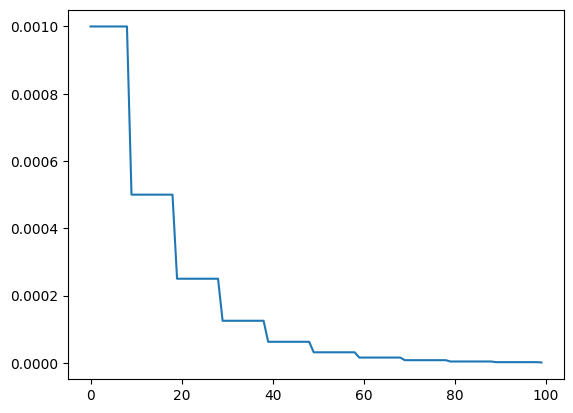

In [26]:
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = optim.SGD(nn.Conv2d(1, 3, 3).parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

lr = []
for i in range(100):
    optimizer.step()  # Call optimizer.step() first
    scheduler.step()
    lr.append(scheduler.get_last_lr()[0])

plt.plot(lr)

### MultiStepLR

- 지정한 Epoch에서 gamma를 LR에 곱하여 LR을 조절합니다.
- **line 02**] 50, 75 epoch에서 0.5를 곱한다.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


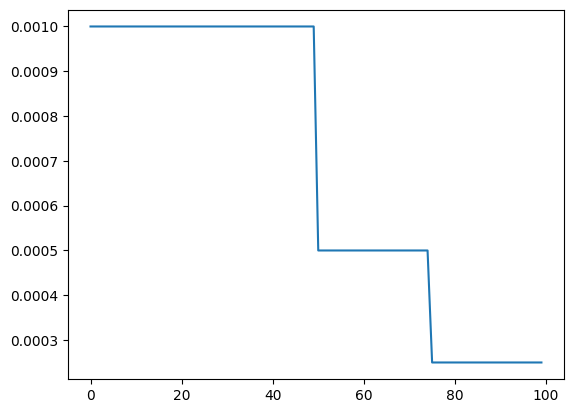

In [27]:
optimizer = optim.SGD(nn.Conv2d(1, 3, 3).parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.5)

lr = []
for i in range(100):
    lr.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(lr)

### CosineAnnealingLR

- LR이 cosine 함수를 따라서 eta_min까지 내려가다가 다시 초기 LR로 올라오는것을 반복합니다.
- T_max * 2 를 주기로 오르락 내리락 하게됩니다.
- **line 02**] 20주기로 오르락 내리락하며 최소 하락폭은 0까지이다.

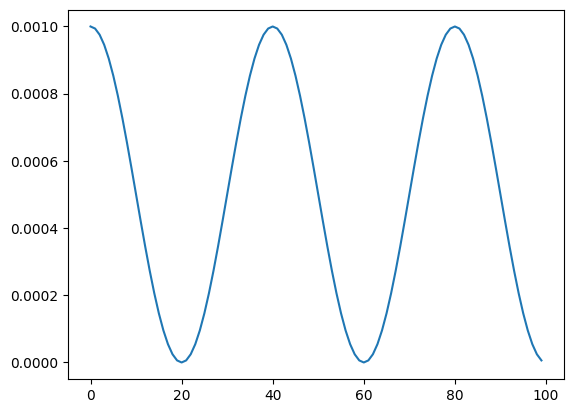

In [28]:
optimizer = optim.SGD(nn.Conv2d(1, 3, 3).parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

lr = []
for i in range(100):
    lr.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(lr)

### ReduceLROnPlateau

- **성능 향상이 없다고 판단 될 때, LR을 감소시킵니다.** schduler에게 어떤 성능을 기준으로 할지 지표를 전달해 주어야합니다.
- 많은 실험에서 가장 좋은 성능을 보이는 경향이 있음

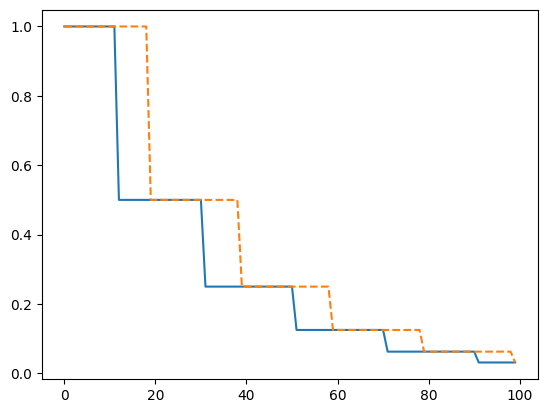

In [29]:
optimizer = optim.SGD(nn.Conv2d(1, 3, 3).parameters(), lr=1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

lr = []
loss = 1.0
losses = []
for i in range(100):
    if i % 20 == 19:
        loss *= 0.5
    losses.append(loss)
    lr.append(optimizer.param_groups[0]['lr'])
    scheduler.step(loss)

plt.plot(lr)
plt.plot(losses, linestyle='dashed')

## **FMNIST with LR Schduler**

- 여러가지 LR Schduler를 실제 프로젝트에 사용해보겠습니다.
- StepLR과 ReduceLROnPlateau를 이용하여 학습을 해보고 결과를 비교해 보겠습니다.

### BaseLine (No Scheduler)

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 15 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | ***SGD*** |
| + Learning Rate | 0.01 |
| + Momentum | ***0.9*** |
| Scheduler | None |

In [30]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Scheduler/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'No-Scheduler_{timestamp}'

# Hyperparameters
EPOCH = 15
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 1.6431 train acc: 25803/48000 (53.76%)
[0] valid loss: 1.2331 valid acc: 8249/12000 (68.74%)

[1] train loss: 1.0373 train acc: 34491/48000 (71.86%)
[1] valid loss: 0.8844 valid acc: 8899/12000 (74.16%)

[2] train loss: 0.7952 train acc: 36354/48000 (75.74%)
[2] valid loss: 0.7252 valid acc: 9218/12000 (76.82%)

[3] train loss: 0.6765 train acc: 37466/48000 (78.05%)
[3] valid loss: 0.6407 valid acc: 9497/12000 (79.14%)

[4] train loss: 0.6041 train acc: 38456/48000 (80.12%)
[4] valid loss: 0.5876 valid acc: 9680/12000 (80.67%)

[5] train loss: 0.5525 train acc: 39162/48000 (81.59%)
[5] valid loss: 0.5388 valid acc: 9776/12000 (81.47%)

[6] train loss: 0.5133 train acc: 39809/48000 (82.94%)
[6] valid loss: 0.4995 valid acc: 9958/12000 (82.98%)

[7] train loss: 0.4825 train acc: 40187/48000 (83.72%)
[7] valid loss: 0.4809 valid acc: 10022/12000 (83.52%)

[8] train loss: 0.4577 train acc: 40618/48000 (84.62%)
[8] valid loss: 0.4663 valid acc: 10021/12000 (83.51%)

[9] trai

In [31]:
# %load_ext tensorboard
# %tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Scheduler'

### StepLR

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 15 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | ***SGD*** |
| + Learning Rate | 0.01 |
| + Momentum | ***0.9*** |
| Schduler | StepLR |
| + Step | 5 |
| + Gamma | 0.5 |

In [32]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Scheduler/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'StepLR_{timestamp}'

# Hyperparameters
EPOCH = 15
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.5)


# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  scheduler.step()

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 1.6455 train acc: 26502/48000 (55.21%)
[0] valid loss: 1.1999 valid acc: 8497/12000 (70.81%)

[1] train loss: 1.0103 train acc: 35015/48000 (72.95%)
[1] valid loss: 0.8702 valid acc: 8933/12000 (74.44%)

[2] train loss: 0.7922 train acc: 36345/48000 (75.72%)
[2] valid loss: 0.7346 valid acc: 9129/12000 (76.07%)

[3] train loss: 0.6864 train acc: 37191/48000 (77.48%)
[3] valid loss: 0.6556 valid acc: 9322/12000 (77.68%)

[4] train loss: 0.6186 train acc: 38058/48000 (79.29%)
[4] valid loss: 0.6007 valid acc: 9627/12000 (80.22%)

[5] train loss: 0.5771 train acc: 38745/48000 (80.72%)
[5] valid loss: 0.5681 valid acc: 9710/12000 (80.92%)

[6] train loss: 0.5556 train acc: 39030/48000 (81.31%)
[6] valid loss: 0.5531 valid acc: 9793/12000 (81.61%)

[7] train loss: 0.5370 train acc: 39345/48000 (81.97%)
[7] valid loss: 0.5400 valid acc: 9744/12000 (81.20%)

[8] train loss: 0.5206 train acc: 39588/48000 (82.47%)
[8] valid loss: 0.5171 valid acc: 9971/12000 (83.09%)

[9] train 

### ReduceLROnPlateau

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 15 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | ***SGD*** |
| + Learning Rate | 0.01 |
| + Momentum | ***0.9*** |
| Schduler | ReduceLROnPlateau |
| + mode | min |
| + factor | 0.5 |
| + threshold | 0.1 |
| + patience | 5 |

In [33]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Scheduler/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'Plateau_{timestamp}'

# Hyperparameters
EPOCH = 15
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01
MOMENTUM = 0.9

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.1)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  # writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch + 1)
  scheduler.step(vloss)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 0.8221 train acc: 35305/48000 (73.55%)
[0] valid loss: 0.5944 valid acc: 9386/12000 (78.22%)

[1] train loss: 0.4483 train acc: 40382/48000 (84.13%)
[1] valid loss: 0.4267 valid acc: 10193/12000 (84.94%)

[2] train loss: 0.3769 train acc: 41618/48000 (86.70%)
[2] valid loss: 0.4555 valid acc: 10003/12000 (83.36%)

[3] train loss: 0.3406 train acc: 42204/48000 (87.93%)
[3] valid loss: 0.3561 valid acc: 10454/12000 (87.12%)

[4] train loss: 0.3192 train acc: 42457/48000 (88.45%)
[4] valid loss: 0.5168 valid acc: 9725/12000 (81.04%)

[5] train loss: 0.3018 train acc: 42846/48000 (89.26%)
[5] valid loss: 0.3319 valid acc: 10546/12000 (87.88%)

[6] train loss: 0.2869 train acc: 43116/48000 (89.82%)
[6] valid loss: 0.3435 valid acc: 10519/12000 (87.66%)

[7] train loss: 0.2772 train acc: 43248/48000 (90.10%)
[7] valid loss: 0.3541 valid acc: 10440/12000 (87.00%)

[8] train loss: 0.2675 train acc: 43421/48000 (90.46%)
[8] valid loss: 0.3180 valid acc: 10658/12000 (88.82%)

[9]

##**Data Augementation**

- 오버피팅을 방지하는 여러가지 기술중 하나인 **Data Augmentation(데이터 증강)**에 대해 알아보겠습니다.
- 딥러닝은 큰 차원의 데이터를 다룰수 있는 장점이 있습니다. 하지만 차원의 저주로 인해 큰 차원에 고르게 데이터를 분포시키기 위해서는 매우 많은 데이터가 필요합니다.
- **<u>현실적으로 수집된 데이터는 고르게 분포하지 않는게 대부분입니다. 이를 해결하기위해 기존의 데이터를 다양한 방식으로 변형하여 학습 데이터를 늘리는 데이터 증강기법이 탄생하게 되었습니다.</u>**
- 이번에는 기본적인 데이터 증강 기법을 이용해서 FMNIST를 학습해보겠습니다.
- **Pytorch**에서는 **`torchvision.transforms`**를 통해 다양한 데이터 증강을 시도할 수 있습니다. 일반적으로 많이 사용되는 기법을 알아보겠습니다.
- 하기의 다양한 Augmentation 기법이외에도 https://pytorch.org/vision/stable/transforms.html 에서 다양한 기법을 확인할 수 있습니다.

- 샘플이미지 다운로드와 확인

--2023-10-09 15:35:05--  https://cdn.pixabay.com/photo/2015/09/09/20/38/rubiks-cube-933202_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41537 (41K) [binary/octet-stream]
Saving to: ‘cube.jpg’

cube.jpg            100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2023-10-09 15:35:05 (12.1 MB/s) - ‘cube.jpg’ saved [41537/41537]



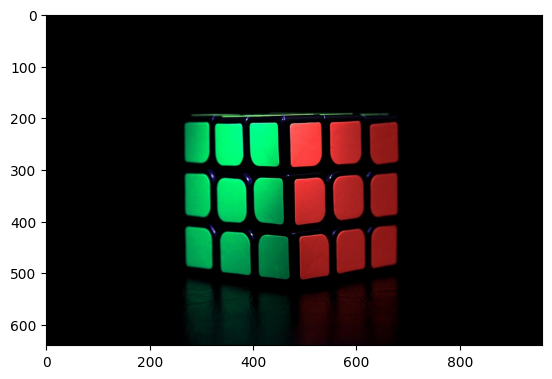

In [34]:
!wget -O cube.jpg https://cdn.pixabay.com/photo/2015/09/09/20/38/rubiks-cube-933202_960_720.jpg

%matplotlib inline
from PIL import Image
image = Image.open("cube.jpg", "r")
plt.imshow(np.asarray(image))

### **Resize**

- 샘플이미지의 크기는 일정하지 않기 때문에 이미지 크기를 맞추기 위해 Resize를 많이 사용합니다.

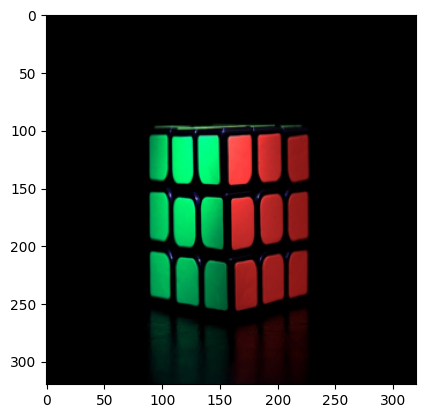

In [35]:
resize = transforms.Resize((320, 320))
plt.imshow(resize(image))

### **Crop**

- Crop은 이미지를 일부만 잘라내는 방법입니다. 일반적으로 학습할 때는 다양한 이미지를 만들기 위해 RandomCrop을 많이 사용합니다.

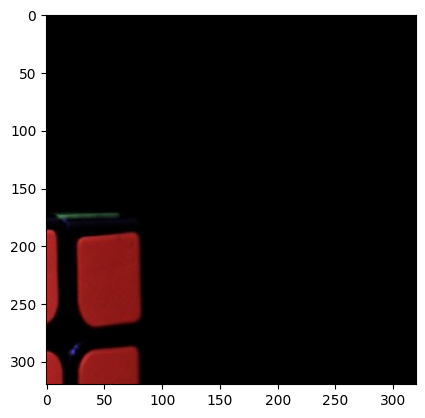

In [36]:
crop = transforms.RandomCrop((320, 320))
plt.imshow(crop(image))

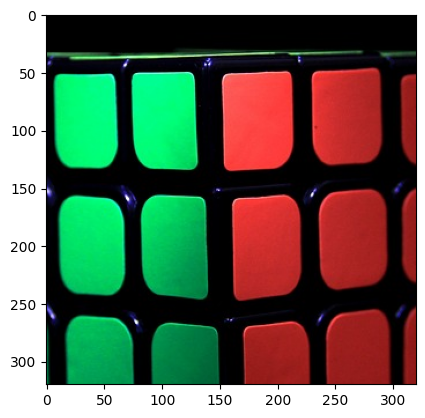

In [37]:
crop = transforms.CenterCrop((320, 320))
plt.imshow(crop(image))

### **Random Resize and Crop**

- Resize후에 Crop을 하는 것을 많이 사용하기 때문에 이를 한번에 해주는 함수인 RandomResizedCrop를 사용해봅니다.

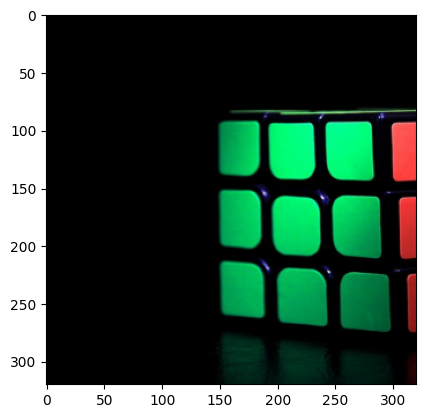

In [38]:
crop = transforms.RandomResizedCrop((320, 320))
plt.imshow(crop(image))

### **Pad**
- Crop, Resize를 사용하기에 이미지가 너무 작은 경우 pad를 이용하여 이미지 가장자리를 늘린 후 다른 transform을 사용합니다.

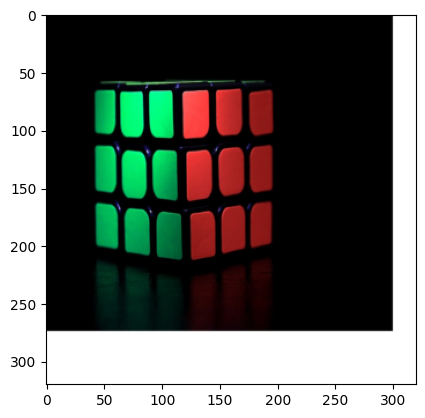

In [39]:
pad = transforms.Pad(100, fill=255)
crop = transforms.RandomResizedCrop((320, 320))
plt.imshow(crop(pad(image)))

### **Flip**

- Flip은 이미지를 반전 시키는 방법으로 좌우반전과, 상하반전 두가지 방식이 있습니다.

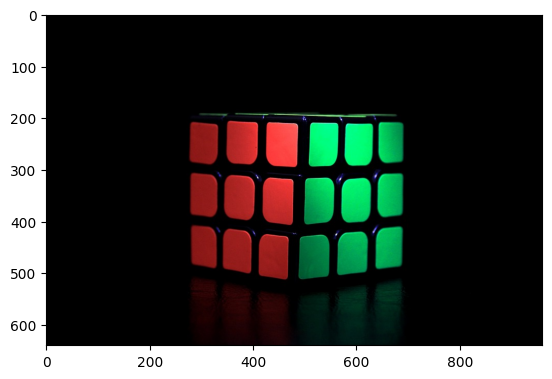

In [40]:
flip = transforms.RandomHorizontalFlip(p=0.5)
plt.imshow(flip(image))

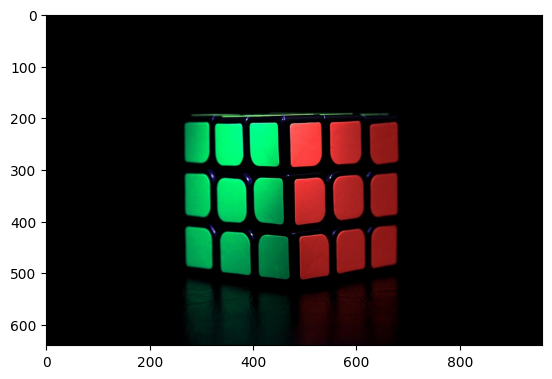

In [41]:
flip = transforms.RandomVerticalFlip(p=0.5)
plt.imshow(flip(image))

### **Rotation**
- 이미지를 회전시킵니다.

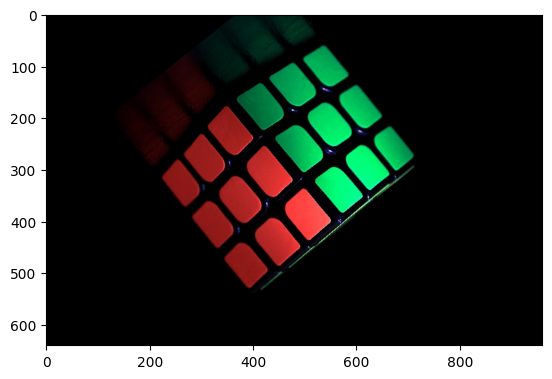

In [42]:
rot = transforms.RandomRotation(degrees=[-180, 180])
plt.imshow(rot(image))

### **ColorJitter**

- 이미지의 색상을 조절할 수있습니다. 밝기, 대비, 채도, 색상을 랜덤하게 조절합니다.

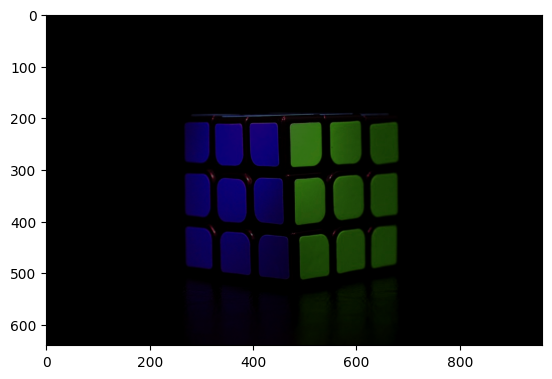

In [43]:
color = transforms.ColorJitter(brightness=0.7, contrast=0.2, saturation=0.2, hue=0.5)
plt.imshow(color(image))

## Data Augmentation with FMNIST

- 이제 FMNIST에 Data Augmentation을 적용해 보겠습니다.
- transform은 Dataset에 지정할 수 있습니다. get_fmnist_dataloaders를 약간 수정해서 transform을 받아오게 합니다.

In [44]:
from torch.utils.data import random_split

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def get_fmnist_dataloaders(batch_size, val=0.2, num_workers=0, train_transform=[transforms.ToTensor()], test_transform=[transforms.ToTensor()]):
  # transform
  train_transform = transforms.Compose(train_transform)
  test_transform = transforms.Compose(test_transform)

  # split                       v FashinMNIST 불러오기
  mnist_train_origin = datasets.FashionMNIST(root='fmnist', train=True, download=True)
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples
  mnist_train, mnist_val = random_split(mnist_train_origin, (train_samples, val_samples))

  # dataset                            v 각 데이터셋 별로 transform 주기
  mnist_train = MyDataset(mnist_train, transform=train_transform)
  mnist_val = MyDataset(mnist_val, transform=test_transform)
  mnist_test = datasets.FashionMNIST(root='fmnist', train=False, download=True, transform=test_transform)

  # dataloader
  train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = DataLoader(dataset=mnist_val, batch_size=batch_size, num_workers=num_workers)
  test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, num_workers=num_workers)

  return train_loader, val_loader, test_loader

### No Data Augmentation

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 15 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | SGD |
| + Learning Rate | 0.01 |
| + Momentum | 0.9 |
| Schduler | ReduceLROnPlateau |
| + mode | min |
| + factor | 0.5 |
| Data Augmentation | ***No*** |

In [45]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Aug/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'No-Aug_{timestamp}'

# Hyperparameters
EPOCH = 30
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01
MOMENTUM = 0.9

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  scheduler.step(vloss)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 0.8990 train acc: 33944/48000 (70.72%)
[0] valid loss: 0.5627 valid acc: 9557/12000 (79.64%)

[1] train loss: 0.4768 train acc: 39909/48000 (83.14%)
[1] valid loss: 0.5046 valid acc: 9819/12000 (81.82%)

[2] train loss: 0.3964 train acc: 41284/48000 (86.01%)
[2] valid loss: 0.4289 valid acc: 10144/12000 (84.53%)

[3] train loss: 0.3588 train acc: 41843/48000 (87.17%)
[3] valid loss: 0.3471 valid acc: 10547/12000 (87.89%)

[4] train loss: 0.3287 train acc: 42372/48000 (88.28%)
[4] valid loss: 0.3402 valid acc: 10486/12000 (87.38%)

[5] train loss: 0.3127 train acc: 42583/48000 (88.71%)
[5] valid loss: 0.4019 valid acc: 10314/12000 (85.95%)

[6] train loss: 0.2983 train acc: 42837/48000 (89.24%)
[6] valid loss: 0.3596 valid acc: 10378/12000 (86.48%)

[7] train loss: 0.2908 train acc: 42944/48000 (89.47%)
[7] valid loss: 0.3017 valid acc: 10655/12000 (88.79%)

[8] train loss: 0.2807 train acc: 43154/48000 (89.90%)
[8] valid loss: 0.2951 valid acc: 10704/12000 (89.20%)

[9]

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Aug/'

### Data Augmentation

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 15 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | SGD |
| + Learning Rate | 0.01 |
| + Momentum | 0.9 |
| Schduler | ReduceLROnPlateau |
| + mode | min |
| + factor | 0.5 |
| Data Augmentation | ***Yes*** |
| + RandomResizedCrop | ***(28, 28)*** |
| + RandomHorizeontalFlip | ***0.5*** |

In [46]:
# from torchvision.transforms.transforms import RandomRotation
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Aug/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'Aug_{timestamp}'

# Hyperparameters
EPOCH = 30
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.01
MOMENTUM = 0.9

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
transform = [
  transforms.Pad(4),
  transforms.RandomResizedCrop((28, 28)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
]
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS, train_transform=transform)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  scheduler.step(vloss)

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

[0] train loss: 1.3863 train acc: 24770/48000 (51.60%)
[0] valid loss: 0.7989 valid acc: 8507/12000 (70.89%)

[1] train loss: 1.0177 train acc: 30567/48000 (63.68%)
[1] valid loss: 0.6129 valid acc: 9278/12000 (77.32%)

[2] train loss: 0.9279 train acc: 31988/48000 (66.64%)
[2] valid loss: 0.6054 valid acc: 9289/12000 (77.41%)

[3] train loss: 0.8772 train acc: 32758/48000 (68.25%)
[3] valid loss: 0.5789 valid acc: 9320/12000 (77.67%)

[4] train loss: 0.8420 train acc: 33284/48000 (69.34%)
[4] valid loss: 0.6557 valid acc: 9215/12000 (76.79%)

[5] train loss: 0.8231 train acc: 33684/48000 (70.18%)
[5] valid loss: 0.5285 valid acc: 9701/12000 (80.84%)

[6] train loss: 0.8025 train acc: 34026/48000 (70.89%)
[6] valid loss: 0.5192 valid acc: 9724/12000 (81.03%)

[7] train loss: 0.7879 train acc: 34290/48000 (71.44%)
[7] valid loss: 0.4955 valid acc: 9766/12000 (81.38%)

[8] train loss: 0.7790 train acc: 34392/48000 (71.65%)
[8] valid loss: 0.5097 valid acc: 9719/12000 (80.99%)

[9] train 

## **Transfer Learning**

- Transfer Learning은 사전에 특정 테스크를 학습한 모델을 다른 테스크에서 재사용하는 방법입니다.
- 일반적으로 사전에 학습된 테스크는 데이터셋이 매우 많고 어려운 문제를 학습을 시키고, 여기서 학습된 모델을 기반으로 실제 풀려고 하는 테스크의 데이터셋으로 재학습을 시킵니다.
- 사전 학습시킨 Task를 Upstream Task 라고 부르며, 새로운 Task를 Downstream Task라고 부릅니다. 특히 Upstream에서 학습된 모델을 사전 학습 시켰다고 해서 **Pretrained Model**이라고 부릅니다.
- Transfer Learning을 사용하면, 기존 보다 학습 속도가 빨라지고 새로운 태스크를 더 잘 수행하는 경향이 있습니다. 이 때문에 최근 실전 문제를 해결하는데 매우 널리 사용되는 기술입니다.
  
  
  
### **Transfer Learning에도 다양한 방법이 있습니다.**
- fine-tuning: 전체 모델을 재학습합니다.
- freezing/prompt tuning: 모델의 일부만 업데이트 합니다.

## Transfer Learning with FMNIST

이번 강의 실습에서는 ImageNet에서 Pretrain 된 ResNet18모델을 이용하여 FMNIST 문제를 해결해보는 실습을 진행하겠습니다.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
def get_fmnist_dataloaders(batch_size, val=0.2, num_workers=0, train_transform=[transforms.ToTensor()], test_transform=[transforms.ToTensor()]):
  # transform
  train_transform = transforms.Compose(train_transform)
  test_transform = transforms.Compose(test_transform)

  # split                       v FashinMNIST 불러오기
  mnist_train_origin = datasets.FashionMNIST(root='fmnist', train=True, download=True)
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples
  mnist_train, mnist_val = random_split(mnist_train_origin, (train_samples, val_samples))

  # dataset                            v 각 데이터셋 별로 transform 주기
  mnist_train = MyDataset(mnist_train, transform=train_transform)
  mnist_val = MyDataset(mnist_val, transform=test_transform)
  mnist_test = datasets.FashionMNIST(root='fmnist', train=False, download=True, transform=test_transform)

  # dataloader
  train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = DataLoader(dataset=mnist_val, batch_size=batch_size, num_workers=num_workers)
  test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, num_workers=num_workers)

  return train_loader, val_loader, test_loader

get_fmnist_dataloaders(1)

(<torch.utils.data.dataloader.DataLoader at 0x78fc5d81f010>,
 <torch.utils.data.dataloader.DataLoader at 0x78fc5c047130>)

### **Load Pretrained model**

torchvision의 models에는 여러 테스크의 pretrained 된 모델들을 쉽게 불러올 수 있도록 되어있습니다. (https://pytorch.org/vision/stable/models.html)

In [51]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.0MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=10, bias=True)
resnet18

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Transfer Learning

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | ResNet18(ImageNet Pretrained) |
| Epochs | 10 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | Adam |
| + Learning Rate | ***0.001*** |
| Schduler | StepLR |
| + Step | 5 |
|
| Data Augmentation | No |

In [ ]:
# LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/Transfer/'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# EXP = f'Resnet18_{timestamp}'

# Hyperparameters
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001
MOMENTUM = 0.9

# Model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(device)

# MNIST dataloader
transform = [
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
]
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS, train_transform=transform)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Logging
# writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Trainin
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  scheduler.step()

  # writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  # writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  # writer.flush()

test(model, test_loader, device)

LR: [0.001]
[0] train loss: 0.5216 train acc: 38870/48000 (80.98%)
[0] valid loss: 0.3692 valid acc: 10333/12000 (86.11%)

LR: [0.001]
